In [23]:
#!/usr/bin/env python
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from collections import defaultdict
import csv

## Defines
clock_second = 128
volt_usage = 3
r_timer = 32768
 
# Main core
standby_state = 0.5 * pow(10,-6)
active_state = 8 * pow(10,-3) # this value is to be less than 10, probably in the range of 5-10
 
# Radio stuff
rx_state = 18.8 * pow(10,-3)
tx_state = 17.4 * pow(10,-3)

In [3]:
def convert_mA(values):
    out_values = []
    for value in values:
        value = ((value/1000.0)/volt_usage)*1000
        out_values.append(value)
    return out_values

In [10]:
# for P lines
#0-> str,
#1 -> clock_time(),2-> P, 3->rimeaddr_node_addr.u8[0],rimeaddr_node_addr.u8[1], 4-> seqno,
#5 -> all_cpu,6-> all_lpm,7-> all_transmit,8-> all_listen,9-> all_idle_transmit,10-> all_idle_listen,
#11->cpu,12-> lpm,13-> transmit,14-> listen, 15 ->idle_transmit, 16 -> idle_listen, [RADIO STATISTICS...]

def totalConsumption(filelist):
    cpu,lpm,tx,rx = [],[],[],[]
    for name in filelist:
        temp_cpu, temp_lpm, temp_tx, temp_rx = 0,0,0,0
        with open(name, 'rb') as f:
            reader = csv.reader(f,delimiter=' ')
            for row in reader:
                if row[2] is 'P': 
                    temp_cpu += (int(row[11])*(active_state*volt_usage))/r_timer
                    temp_lpm += (int(row[12])*(standby_state*volt_usage))/r_timer
                    temp_tx+= (int(row[13])*(active_state+tx_state)*volt_usage)/r_timer
                    temp_rx += (int(row[11])*(active_state+rx_state)*volt_usage)/r_timer
        cpu.append(temp_cpu)
        lpm.append(temp_lpm)
        tx.append(temp_tx)
        rx.append(temp_rx)
    return cpu, lpm, tx, rx

In [37]:
def mk_2bar_plot(values1, values2, labels,flag):
    y_pos = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots()
    rects1 = ax.bar(y_pos,values1,width,color='#FAA43A')
    rects2 = ax.bar(y_pos,values2,width,bottom=values1,color='#DECF3F')
    
    ax.set_ylabel('Consumption (mA)')
    ax.set_xticks(y_pos + width/2)
    ax.set_xticklabels(labels)
    
    ax.set_xlabel('# of packets')
    ax.set_title('Consumption vs Packet Amount')
    #ax.set_xlabel('Time(s)')
    #ax.set_title('Consumption vs Send intervall')
    
    fontP = FontProperties()
    fontP.set_size('small')
    if flag==0:
        ax.legend((rects1[0], rects2[0]), ('Transmit','Listen'), prop = fontP, loc="upper left")
    if flag==1:
        ax.legend((rects1[0], rects2[0]), ('CPU','LPM'), prop = fontP, loc="upper left")
 
    plt.show()
    

In [40]:
amount = ['log_amount10.txt','log_amount20.txt', 'log_amount30.txt', 'log_amount40.txt', \
          'log_amount50.txt','log_amount60.txt','log_amount70.txt', 'log_amount80.txt', \
          'log_amount90.txt', 'log_amount100.txt', 'log_amount110.txt', 'log_amount120.txt']
amount_labels = ('10', '20', '30','40','50','60', '70', '80','90','100','110','120')

time = ['log_time1.txt','log_time2.txt', 'log_time4.txt', 'log_time8.txt', 'log_time16.txt']
time_labels = ('1', '2', '4','8','16')


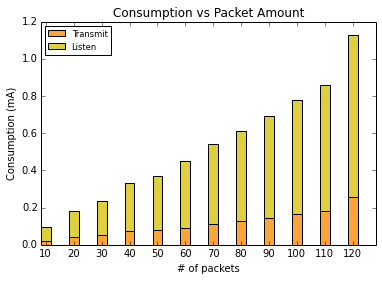

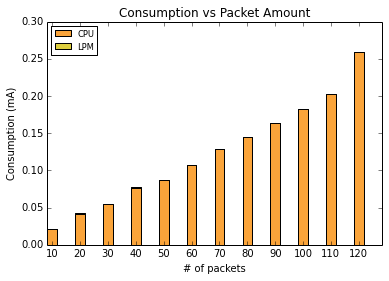

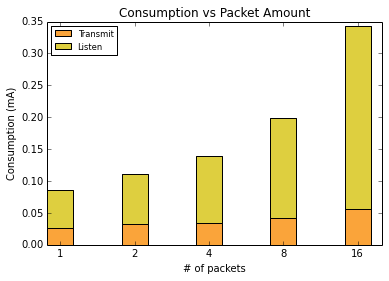

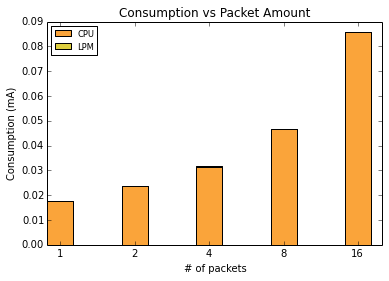

In [41]:
cpu,lpm,tx,rx = totalConsumption(amount)
mk_2bar_plot(convert_mA(tx),convert_mA(rx),amount_labels,0)
mk_2bar_plot(convert_mA(cpu),convert_mA(lpm),amount_labels,1)
cpu,lpm,tx,rx = totalConsumption(time)
mk_2bar_plot(convert_mA(tx),convert_mA(rx),time_labels,0)
mk_2bar_plot(convert_mA(cpu),convert_mA(lpm),time_labels,1)